# DCGAN keras Imagenes 128 x 128 

In [1]:
jupyter notebook --NotebookApp.max_buffer_size=6000000000

SyntaxError: invalid syntax (<ipython-input-1-8d2daf772e1a>, line 1)

In [2]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
from __future__ import print_function, division

#Se importan las bibliotecas. En caso de querer hacer este proceso directamente
#en un ordenador se deben instalar las bilbiotecas que se indican a continuacion:

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
import h5py
import sklearn
import glob
import keras
import time
import imp
import os
import tensorflow as tf 
import pandas as pd
import sys

#Estas bibliotecas no son necesarias en su totalidad, solo se requieren ciertas
#funciones
from random import shuffle
from skimage import io
from collections import Counter
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

from keras.datasets import mnist

#Importe de funciones especificas de bibliotecas ya importadas
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import BatchNormalization, ZeroPadding2D, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.convolutional import UpSampling2D
from keras.optimizers import SGD, Adam

from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm

from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from skimage.transform import resize
from keras.datasets.mnist import load_data

from scipy.stats import wasserstein_distance

#lineas requeridas solo en jupyter notbook
from IPython.display import clear_output
%matplotlib notebook
%matplotlib inline
#%tensorflow_version 2.x

Using TensorFlow backend.


In [4]:
#Se inicia definiendo el diccionario map_characters, este posee originalmente 18
#personajes, si se agrega otro más se debe agregar al diccionario y colocarsele 
#el número consecutivo que corresponda

map_characters = {0: 'trainingCoffee'}
                  
#Se define el numero de clases con la extensión del diccionario
num_classes = len(map_characters)

#Número máximo de imagenes que se usaran por personaje para entrenar
pictures_per_class = 20000

def load_pictures(test_size, pic_size,BGR):
    """
    Load pictures from folders for characters from the map_characters dict and create a numpy dataset and 
    a numpy labels set. Pictures are re-sized into picture_size square.
    :param BGR: boolean to use true color for the picture (RGB instead of BGR for plt)
    :return: dataset, labels set
    """
    pics = []    #Se crea la lista de imagenes de salida
    labels = []  #Se crea la lista de etiquetas de salida

    #k es el numero de la variable en el diccionario
    #char es el nombre de la variable en el diccionario
    # El if lo que hace es que recorra cada una de las variables del diccionario
    for k, char in map_characters.items(): 

        #Esta linea deivuelve la lista de rutas de las imagenes de cada personaje del diccionario
        # Ej: para char = 'abraham_grampa_simpson' regresa todas las rutas de imagen de la carpeta
        # abraham_grampa_simpson que a su vez esta en la carpeta characters.
        #Es solo una forma elegante y rapida de optener todas las rutas
        pictures = [k for k in glob.glob('./source/trainingSet/%s/*' % char)]

        #Se establece la cantidad de imagenes que se van a usar en cada clase
        #Como maximo se usan 1176 imagenes, estas son tanto para train como para test
        #Si el personaje en particular tiene menos de 1176 imagenes se usara la extension del personaje en cuestion
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)

        #Se usa la funcion random para ordenar de manera aleatoria las imagenes de cada personaje
        #Cabe detacar que pic es una ruta de acceso aleatoria de la lista de rutas de acceso en pictures
        for pic in np.random.choice(pictures, nb_pic):

            #Se lee la imagen de la ruta "pic"
            a = cv2.imread(pic)
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
            # a = cv2.imread(pic, cv2.IMREAD_GRAYSCALE)

            #Se hace un resize de las imagenes a pic_size x pic_size. Por defecoto
            #este es 64x64. Esto concuerda con los pixeles de entrada de la red neuronal
            a = cv2.resize(a, (pic_size,pic_size))

            #Se agrega la imagen leida, convertida y escalada a la lista pics
            pics.append(a)
            #Se agrega la etiqueta numérica de la lista de etiquetas, esta etiqueta numerica 
            #concuerda con el número en el diccionario map_characters
            labels.append(k)

    #Se devuelve las listas pero antes se transforman a un formato de array con numpy
    return np.array(pics), np.array(labels) 

def get_dataset(save=False, load=False, BGR=False, test_size=0.1, pic_size=64):
    #Primero se llama a la funcion load_pictures, por defecto se deja estas en 
    #blanco y negro
    #En esta funcion tambien se extraen los labels del archivo txt anotations
    X, y = load_pictures(test_size, pic_size, BGR)

    #Luego se pasa los labels a un formato numerico y en listas separadas,
    #por ejemplo si el label es 2 to_categorical lo pasa a una lista [0 0 1 ... 0]
    #El tamaño de la lista depende de cuantas clases se tenga, en este ejemplo son 18
    y = keras.utils.to_categorical(y, num_classes)

    #Se normaliza las imagenes para que los valores de cada banda esten en punto flotante
    #y además se encuentren entre 0 y 1. Esto ayuda a la velocidad de entrenamiento           
    X = X.astype('float32') / 255.
    
    #Se imprime las formas de cada tensor. Si se mantienen todas las variables 
    #por defecto estas deben ser (x,64,64,3) y (x,w), donde x es el numero de imagenes
    #y w es la cantidad de clases en el diccionario
    print("Train", X.shape, y.shape)

    return X, y

#Uso de funciones de lectura para dividir el set de imagnes en test y train
X, y = get_dataset(save=True)

Train (19017, 64, 64, 3) (19017, 1)


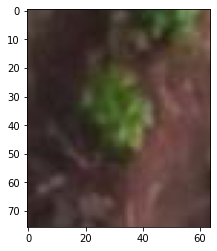

In [5]:
a = cv2.imread('./source/trainingSet/trainingCoffee/000001.jpg')
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)
plt.show()

In [6]:
img_rows = 64
img_cols = 64
channels = 3
latent_dim = 100
img_shape = (img_rows, img_cols, channels)
img_shape


Filtros_Iniciales = 64
upsample_layers = 5
Kernels = 3

In [7]:
def build_generator():
    noise_shape = (latent_dim,)
    
    model = Sequential()

    model.add(Dense(Filtros_Iniciales * (img_rows // (2 ** upsample_layers))  *  (img_cols // (2 ** upsample_layers)), activation="relu", input_shape=noise_shape))
    model.add(Reshape(((img_rows // (2 ** upsample_layers)),
                       (img_cols // (2 ** upsample_layers)),
                       Filtros_Iniciales)))
    
    model.add(BatchNormalization(momentum=0.8))
        
    model.add(UpSampling2D())
    model.add(Conv2D(1024, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(512, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(256, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))

    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=Kernels, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(channels, kernel_size=Kernels, padding="same"))
    model.add(Activation("tanh"))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(latent_dim,))
    fake_img = model(noise)

    return Model(noise, fake_img)


#####
def build_discriminator():

    #Se crea primeramente un modelo "Sequential", este es el tipo de red neuronal
    #existen otros tipos como las recursivas y las recurrentes.
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=img_shape))
    model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    #Finalmente se reduce a la cantidad de neuronas equivalentes a la cantidad de clases
    #que se desean, en nuestro caso, la cantidad de personajes que estamos clasificando
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [8]:
#-------------------------------------
itr_list = []
acc_list = []
d_loss_list = []
g_loss_list = []
fid_list = []
wasserstein_distance_list = []

In [9]:
def train(X_train, epochs_inicial, epochs, batch_size=128, save_interval=50):
 
    #La mitad del bach es imagenes falsas y la otra mitad imagenes reales
    half_batch = int(batch_size / 2)

    # Adversarial ground truths
    valid = np.ones((half_batch, 1))
    fake = np.zeros((half_batch, 1))
    
    for epoch in range(epochs_inicial, epochs):

        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        # Se seleccionan imagenes aleatorias para hacer la epoca
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # El generador da un numero de imagenes sinteticas para la epoca
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        gen_imgs = generator.predict(noise)

        #Se entrena con las imagenes reales
        d_loss_real = discriminator.train_on_batch(imgs, valid)
        
        #Se entrena con las imagenes creadas como falsas
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        # ---------------------
        #  Train Generator
        # ---------------------

        # Se ingresa el ruido al generador y la idea es que
        # el generador engañe al discriminador para que piense que es
        # una imagen real, por eso ponemos que el ruido es valido
        # Aqui solo se modifian los pesos del generador
        g_loss = combined.train_on_batch(noise, valid)
        
        #------------------------------------------
        # Calculo de Frechet Inception Distance
        #------------------------------------------

        # Se seleccionan imagenes aleatorias para hacer la epoca
        idx = np.random.randint(0, X_train.shape[0], 128)
        imgs = X_train[idx]

        # El generador da un numero de imagenes sinteticas para la epoca
        noise = np.random.normal(0, 1, (128, latent_dim))
        gen_imgs = generator.predict(noise)
        
        # resize images
        images1 = scale_images(imgs, (128,128,3))
        images2 = scale_images(gen_imgs, (128,128,3))

        # pre-process images
        images1 = preprocess_input(images1)
        images2 = preprocess_input(images2)

        # calculate fid
        fid = calculate_fid(model, images1, images2)
        fid_list.append(fid)
        
        #---------------------------
        # wasserstein_distance
        #--------------------------
        
        wasserstein_distance_list.append(wasserstein_distance([d_loss[0]], [g_loss]))       
        
        #----------------------------------------------------------------------
        #Se guarda los resultados en una lista
        itr_list.append(epoch)
        acc_list.append(100*d_loss[1])
        d_loss_list.append(d_loss[0])
        g_loss_list.append(g_loss)
        
        #----------------------------------------------------------------------
        f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex='col', figsize=(13,7))

        ax1.plot(itr_list, d_loss_list, label = "Discriminator Loss")
        ax1.plot(itr_list, g_loss_list, label = "Generator Loss")
        ax1.legend()

        #
        ax2.plot(itr_list, wasserstein_distance_list, '-b', label = "Wasserstein Distance")
        ax2.legend()
        
        #
        ax3.plot(itr_list, fid_list, '-g', label = "Frechet Inception Distance")
        ax3.legend()
        
        # Create two subplots and unpack the output array immediately
        ax4.plot(itr_list, acc_list, '-r', label = "Discriminator Accuracy")
        ax4.legend()
        
        plt.pause(0.02)
        clear_output(wait=True)
        
        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)
            
        if epoch == epochs - 1:
            #Cuendo termina el entrenamiento se guardan en un df
            df = pd.DataFrame()
            df['itr'] = itr_list
            df['acc'] = acc_list
            df['d_loss'] = d_loss_list
            df['g_loss'] = g_loss_list
            df['w_distance'] = wasserstein_distance_list
            df['fid'] = fid_list
            df.to_csv('results.csv', index=False)    

## Calculo del FID

https://keras.io/api/applications/inceptionresnetv2/
https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/


In [10]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)

# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(128, 128, 3))
model = InceptionV3(input_tensor=input_tensor, weights='imagenet', include_top=True)

In [11]:
def save_imgs(epoch):
    noise = np.random.normal(0, 1, (1, latent_dim))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = abs(gen_imgs)
    gen_imgs = (abs(gen_imgs) * 255.).astype(int)

    fig = plt.gcf()
    fig.set_size_inches(64/71.5, 64/71.5)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.axis('off')
    fig.add_axes(ax)
    ax.imshow(gen_imgs[0])
    fig.savefig("ResultadosCafe/mnist_%d.png" % epoch)
    plt.close()

# Main part

## Entrenamiento desde cero

In [126]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_615 (Conv2D)          (None, 64, 64, 32)        896       
_________________________________________________________________
activation_620 (Activation)  (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_616 (Conv2D)          (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_621 (Activation)  (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_617 (Conv2D)          (None, 31, 31, 64)      

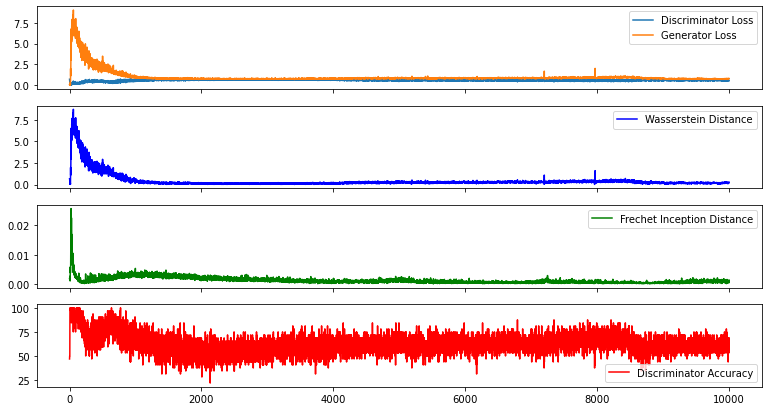

In [127]:
#Train!!!
train(X, epochs_inicial=0, epochs=10001, batch_size=32, save_interval=500)

## Entrenamiento desde un punto especifico

In [13]:
Data = pd.read_csv('results.csv')
itr_list = list(Data.itr)
acc_list = list(Data.acc)
d_loss_list = list(Data.d_loss)
g_loss_list = list(Data.g_loss)
wasserstein_distance_list = list(Data.w_distance)
fid_list = list(Data.fid)

In [14]:
#Imprime la ultima iteracion guardada
itr_list[-1]

37375

In [15]:
optimizer = Adam(0.0002, 0.5)

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.load_weights('discriminator_64_64_weigths.h5')
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Build the generator
generator = build_generator()
generator.load_weights('generator_64_64_weigths.h5')
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_95 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_95 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_96 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 31, 31, 64)       

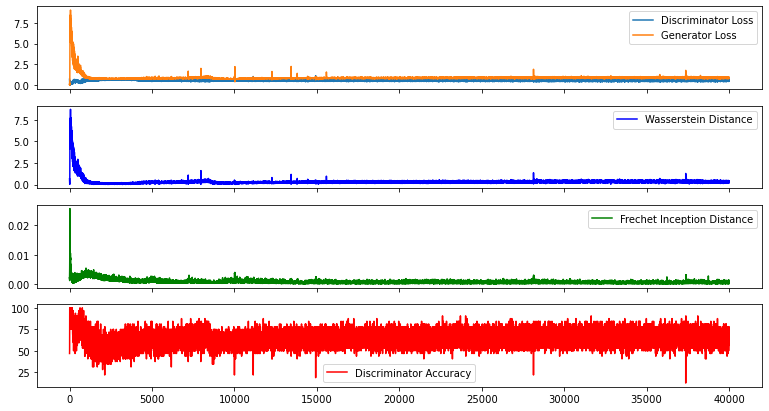

In [16]:
train(X, epochs_inicial= 37375, epochs=40001, batch_size=32, save_interval=500)

In [17]:
generator.save_weights('generator_64_64_weigths.h5')
discriminator.save_weights('discriminator_64_64_weigths.h5')
combined.save_weights('combined_64_64_weigths.h5')

# Guardado de resultados

In [17]:
#Cuendo termina el entrenamiento se guardan en un df
df = pd.DataFrame()
df['itr'] = itr_list
df['acc'] = acc_list
df['d_loss'] = d_loss_list
df['g_loss'] = g_loss_list
df['w_distance'] = wasserstein_distance_list
df['fid'] = fid_list
df.to_csv('results.csv', index=False)    

In [129]:
generator.save_weights('generator_64_64_weigths.h5')
discriminator.save_weights('discriminator_64_64_weigths.h5')
combined.save_weights('combined_64_64_weigths.h5')

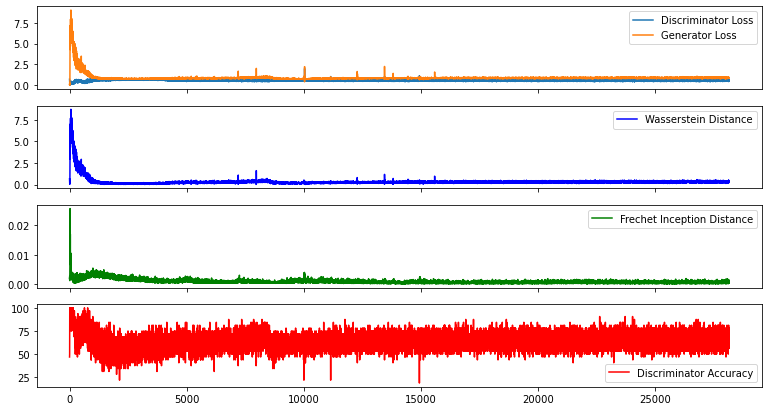

In [61]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex='col', figsize=(13,7))

ax1.plot(itr_list, d_loss_list, label = "Discriminator Loss")
ax1.plot(itr_list, g_loss_list, label = "Generator Loss")
ax1.legend()

#
ax2.plot(itr_list, wasserstein_distance_list, '-b', label = "Wasserstein Distance")
ax2.legend()

#
ax3.plot(itr_list, fid_list, '-g', label = "Frechet Inception Distance")
ax3.legend()

# Create two subplots and unpack the output array immediately
ax4.plot(itr_list, acc_list, '-r', label = "Discriminator Accuracy")
ax4.legend()

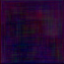

In [13]:
from IPython.display import display
from PIL import Image

path="ResultadosCafe/mnist_0.png"
display(Image.open(path))

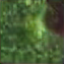

In [12]:
from IPython.display import display
from PIL import Image

path="ResultadosCafe/mnist_40000.png"
display(Image.open(path))

# Test con pesos guardados

In [14]:
optimizer = Adam(0.0002, 0.5)

new_model = build_generator()
new_model.compile(loss='binary_crossentropy', optimizer=optimizer)

new_model.load_weights('generator_64_64_weigths.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
reshape_1 (Reshape)          (None, 2, 2, 64)          0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 2, 2, 64)          256       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_95 (Conv2D)           (None, 4, 4, 1024)        590848    
_________________________________________________________________
activation_95 (Activation)   (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 4, 4, 1024)       

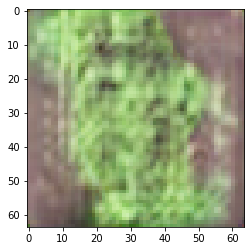

In [66]:
noise = np.random.normal(0, 1, (1,latent_dim))
gen_imgs = new_model.predict(noise)

gen_imgs2 = abs(gen_imgs)

plt.imshow((gen_imgs2[0] * 255).astype(int))
plt.show()

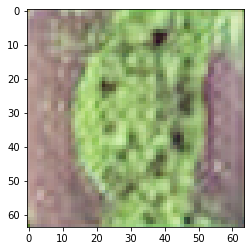

In [113]:
noise = np.random.normal(0, 1, (1,latent_dim))
gen_imgs = new_model.predict(noise)

gen_imgs2 = abs(gen_imgs)

plt.imshow((gen_imgs2[0] * 255).astype(int))
plt.show()

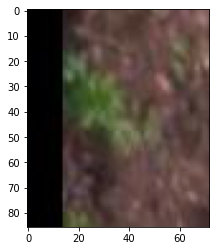

In [20]:
a = cv2.imread('./source/trainingSet/trainingCoffee/000004.jpg')
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)
plt.show()

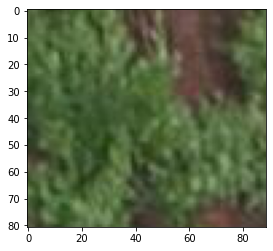

In [21]:
a = cv2.imread('./source/trainingSet/trainingCoffee/000130.jpg')
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)
plt.show()

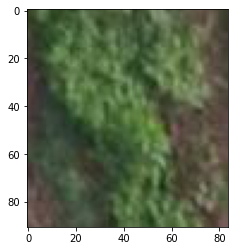

In [30]:
a = cv2.imread('./source/trainingSet/trainingCoffee/000302.jpg')
a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
plt.imshow(a)
plt.show()

# Información

## https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wasserstein_distance.html


https://rdrr.io/cran/transport/man/wasserstein.html#:~:text=The%20Wasserstein%20distance%20of%20order%20p%20is%20defined%20as%20the,p%20of%20the%20Euclidean%20distance.